IMPORTS

In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
%matplotlib inline
import cv2
import glob
import keras
from IPython.display import Image
from sklearn import metrics
from sklearn import datasets,linear_model, preprocessing,utils
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure, show
from keras.layers import Conv1D, Conv2D, MaxPooling2D 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten ,Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from IPython.display import Image

HELPER FUNCTIONS


In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

    
def get_outliers_row_idecies(df, name, sd):
    outliers_row_indecies = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    return outliers_row_indecies

# Regression chart.

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show() 

IMPORTING TO DRIVE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/Houses Dataset'

 100_bathroom.jpg	 262_bedroom.jpg	 422_kitchen.jpg
 100_bedroom.jpg	 262_frontal.jpg	 423_bathroom.jpg
 100_frontal.jpg	 262_kitchen.jpg	 423_bedroom.jpg
 100_kitchen.jpg	 263_bathroom.jpg	 423_frontal.jpg
 101_bathroom.jpg	 263_bedroom.jpg	 423_kitchen.jpg
 101_bedroom.jpg	 263_frontal.jpg	 424_bathroom.jpg
 101_frontal.jpg	 263_kitchen.jpg	 424_bedroom.jpg
 101_kitchen.jpg	 264_bathroom.jpg	 424_frontal.jpg
 102_bathroom.jpg	 264_bedroom.jpg	 424_kitchen.jpg
 102_bedroom.jpg	 264_frontal.jpg	 425_bathroom.jpg
 102_frontal.jpg	 264_kitchen.jpg	 425_bedroom.jpg
 102_kitchen.jpg	 265_bathroom.jpg	 425_frontal.jpg
 103_bathroom.jpg	 265_bedroom.jpg	 425_kitchen.jpg
 103_bedroom.jpg	 265_frontal.jpg	 426_bathroom.jpg
 103_frontal.jpg	 265_kitchen.jpg	 426_bedroom.jpg
 103_kitchen.jpg	 266_bathroom.jpg	 426_frontal.jpg
 104_bathroom.jpg	 266_bedroom.jpg	 426_kitchen.jpg
 104_bedroom.jpg	 266_frontal.jpg	 427_bathroom.jpg
 104_frontal.jpg	 266_kitchen.jpg	 427_bedroom.jpg
 104_kitchen.jpg	

In [ ]:
cols=[ "bedroom", "bathroom", "area", "zipcode", "price"]

In [ ]:
hp = pd.read_csv("/content/drive/My Drive/Houses Dataset/HousesInfo.txt" , sep=" ", header=None , names=cols)
print(hp.head())

print("\n shape of hp =") , print(hp.shape)

hp.isnull().sum()


   bedroom  bathroom  area  zipcode   price
0        4       4.0  4053    85255  869500
1        4       3.0  3343    36372  865200
2        3       4.0  3923    85266  889000
3        5       5.0  4022    85262  910000
4        3       4.0  4116    85266  971226

 shape of hp =
(535, 5)


bedroom     0
bathroom    0
area        0
zipcode     0
price       0
dtype: int64

In [ ]:
hp.describe()

,bedroom,bathroom,area,zipcode,price
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,90937.768224,5.893628e+05
std,1.160952,0.995077,1224.556982,7141.857452,5.090261e+05
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


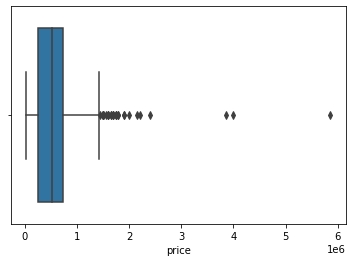

In [ ]:
sns.boxplot(hp['price'])

In [ ]:
img_path = "/content/drive/My Drive/Houses Dataset/"

In [ ]:
## Bathroom.jpg
new_images=[]
for number in range(1, hp.shape[0] + 1):
    for path in glob.glob(img_path + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path)

In [ ]:
new_images[:10]

['/content/drive/My Drive/Houses Dataset/1_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/2_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/3_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/4_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/5_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/6_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/7_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/8_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/9_bathroom.jpg',
 '/content/drive/My Drive/Houses Dataset/10_bathroom.jpg']

In [ ]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [ ]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob(img_path + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 
            

In [ ]:
img['bedroom_img']=bedroom_images

In [ ]:
frontal_images = []
for number in range(1, 536):
    for path in glob.glob(img_path + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path)

In [ ]:
img['frontal_img']=frontal_images

In [ ]:
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob(img_path + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

In [ ]:
img['kitchen_img']=kitchen_images

In [ ]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,/content/drive/My Drive/Houses Dataset/1_bathr...,/content/drive/My Drive/Houses Dataset/1_bedro...,/content/drive/My Drive/Houses Dataset/1_front...,/content/drive/My Drive/Houses Dataset/1_kitch...
1,/content/drive/My Drive/Houses Dataset/2_bathr...,/content/drive/My Drive/Houses Dataset/2_bedro...,/content/drive/My Drive/Houses Dataset/2_front...,/content/drive/My Drive/Houses Dataset/2_kitch...
2,/content/drive/My Drive/Houses Dataset/3_bathr...,/content/drive/My Drive/Houses Dataset/3_bedro...,/content/drive/My Drive/Houses Dataset/3_front...,/content/drive/My Drive/Houses Dataset/3_kitch...
3,/content/drive/My Drive/Houses Dataset/4_bathr...,/content/drive/My Drive/Houses Dataset/4_bedro...,/content/drive/My Drive/Houses Dataset/4_front...,/content/drive/My Drive/Houses Dataset/4_kitch...
4,/content/drive/My Drive/Houses Dataset/5_bathr...,/content/drive/My Drive/Houses Dataset/5_bedro...,/content/drive/My Drive/Houses Dataset/5_front...,/content/drive/My Drive/Houses Dataset/5_kitch...


In [ ]:
img.shape

(535, 4)

COMBINING TEXT AND IMAGE DATA


In [ ]:
final = pd.concat([hp, img], axis=1, sort=False)
print(final.shape)
print(list(final.columns))
final[:5]

(535, 9)
['bedroom', 'bathroom', 'area', 'zipcode', 'price', 'bathroom_img', 'bedroom_img', 'frontal_img', 'kitchen_img']


,bedroom,bathroom,area,zipcode,price,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,4,4.0,4053,85255,869500,/content/drive/My Drive/Houses Dataset/1_bathr...,/content/drive/My Drive/Houses Dataset/1_bedro...,/content/drive/My Drive/Houses Dataset/1_front...,/content/drive/My Drive/Houses Dataset/1_kitch...
1,4,3.0,3343,36372,865200,/content/drive/My Drive/Houses Dataset/2_bathr...,/content/drive/My Drive/Houses Dataset/2_bedro...,/content/drive/My Drive/Houses Dataset/2_front...,/content/drive/My Drive/Houses Dataset/2_kitch...
2,3,4.0,3923,85266,889000,/content/drive/My Drive/Houses Dataset/3_bathr...,/content/drive/My Drive/Houses Dataset/3_bedro...,/content/drive/My Drive/Houses Dataset/3_front...,/content/drive/My Drive/Houses Dataset/3_kitch...
3,5,5.0,4022,85262,910000,/content/drive/My Drive/Houses Dataset/4_bathr...,/content/drive/My Drive/Houses Dataset/4_bedro...,/content/drive/My Drive/Houses Dataset/4_front...,/content/drive/My Drive/Houses Dataset/4_kitch...
4,3,4.0,4116,85266,971226,/content/drive/My Drive/Houses Dataset/5_bathr...,/content/drive/My Drive/Houses Dataset/5_bedro...,/content/drive/My Drive/Houses Dataset/5_front...,/content/drive/My Drive/Houses Dataset/5_kitch...


Houses with a price between 100K and 900K
 

In [ ]:
result = final[final['price'] >=100000] 
result = result[result['price'] <=900000] 

print(result.shape)

(406, 9)


In [ ]:
img = result.drop(columns =['bedroom',	'bathroom',	'area',	'zipcode',	'price'], inplace = False) 

print(img.shape)
img.head()

(406, 4)


,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,/content/drive/My Drive/Houses Dataset/1_bathr...,/content/drive/My Drive/Houses Dataset/1_bedro...,/content/drive/My Drive/Houses Dataset/1_front...,/content/drive/My Drive/Houses Dataset/1_kitch...
1,/content/drive/My Drive/Houses Dataset/2_bathr...,/content/drive/My Drive/Houses Dataset/2_bedro...,/content/drive/My Drive/Houses Dataset/2_front...,/content/drive/My Drive/Houses Dataset/2_kitch...
2,/content/drive/My Drive/Houses Dataset/3_bathr...,/content/drive/My Drive/Houses Dataset/3_bedro...,/content/drive/My Drive/Houses Dataset/3_front...,/content/drive/My Drive/Houses Dataset/3_kitch...
6,/content/drive/My Drive/Houses Dataset/7_bathr...,/content/drive/My Drive/Houses Dataset/7_bedro...,/content/drive/My Drive/Houses Dataset/7_front...,/content/drive/My Drive/Houses Dataset/7_kitch...
10,/content/drive/My Drive/Houses Dataset/11_bath...,/content/drive/My Drive/Houses Dataset/11_bedr...,/content/drive/My Drive/Houses Dataset/11_fron...,/content/drive/My Drive/Houses Dataset/11_kitc...


In [ ]:
text = result.drop(columns =['bathroom_img',	'bedroom_img',	'frontal_img',	'kitchen_img'], inplace = False) 
print(text.shape)
text.head()

(406, 5)


,bedroom,bathroom,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200


Concatenate all  Images into one image for each house


In [ ]:
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]
            
        
            images_output.append(outputImage)      
            

In [ ]:
img_arr=np.asarray(images_output)
img_arr.shape

(406, 128, 128, 3)

In [ ]:
text.shape, img_arr.shape

((406, 5), (406, 128, 128, 3))

In [ ]:

x_text = text.drop(columns=['price'], inplace=False)
print(x_text.head())


y_text = pd.DataFrame()
y_text['price'] = text['price']
print(y_text.head())

    bedroom  bathroom  area  zipcode
0         4       4.0  4053    85255
1         4       3.0  3343    36372
2         3       4.0  3923    85266
6         3       4.0  2544    85262
10        5       5.0  4829    85266
     price
0   869500
1   865200
2   889000
6   799000
10  519200


ONE HOT ENCODED CATEGORICAL VALUES

In [ ]:
categorical_features = ['bedroom', 'bathroom', 'zipcode']

for categorical_feature in categorical_features:
  encode_text_dummy(x_text, categorical_feature)

NORMALIZATION

In [ ]:
encode_numeric_zscore(x_text, 'area')

x_text.head()

,area,bedroom-1,bedroom-2,bedroom-3,bedroom-4,bedroom-5,bedroom-6,bedroom-7,bedroom-8,bedroom-10,bathroom-1.0,bathroom-1.5,bathroom-2.0,bathroom-2.5,bathroom-3.0,bathroom-3.25,bathroom-3.5,bathroom-4.0,bathroom-4.5,bathroom-5.0,bathroom-6.0,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,zipcode-62234,zipcode-62249,zipcode-81418,zipcode-81521,zipcode-81524,zipcode-85255,zipcode-85262,zipcode-85266,zipcode-85331,zipcode-91752,zipcode-91901,zipcode-91915,zipcode-92021,zipcode-92253,zipcode-92276,zipcode-92543,zipcode-92677,zipcode-92692,zipcode-92802,zipcode-92880,zipcode-93105,zipcode-93111,zipcode-93314,zipcode-93446,zipcode-93510,zipcode-94501,zipcode-94531,zipcode-94565,zipcode-94568,zipcode-95220,zipcode-96019,zipcode-98021
0,1.541416,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.918549,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.427370,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.217604,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2.222184,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**SPLITIING INTO TEST AND TRAIN DATA**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_text, y_text, test_size=0.3, random_state=42)
img_train, img_test = train_test_split(img_arr, test_size=0.3, shuffle=False, stratify=None)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(img_train.shape)
print(img_test.shape)

(284, 61)
(284, 1)
(122, 61)
(122, 1)
(284, 128, 128, 3)
(122, 128, 128, 3)


**CREATING MODELS CNN and NEURAL NETWORKS**

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 62, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 61)]         0                                            
_______________________________________________________________________________________

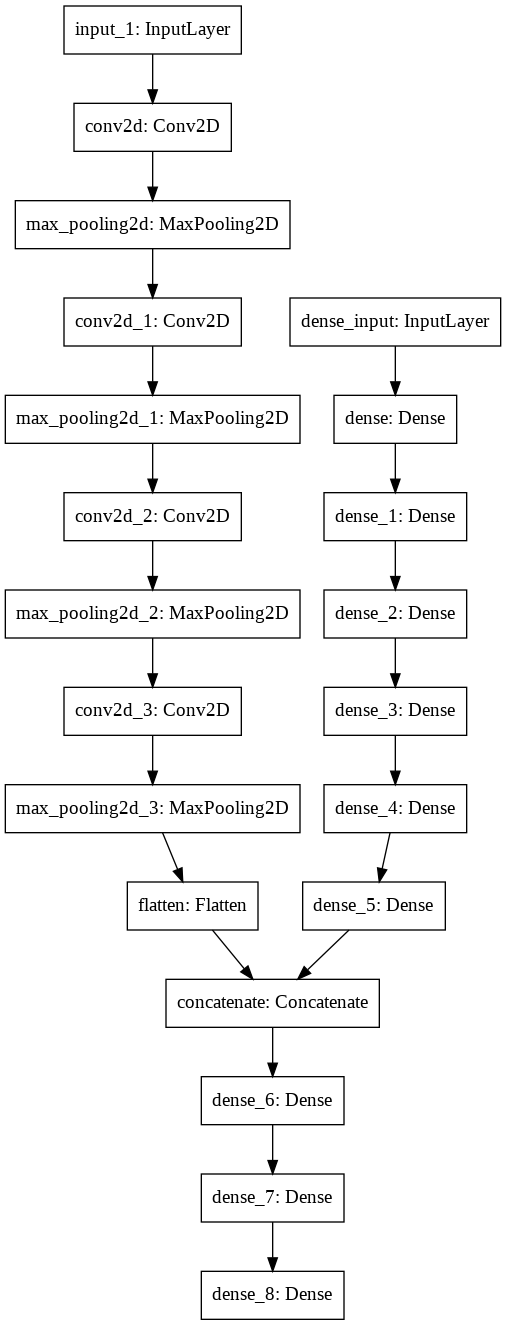

In [ ]:
#Model1
model1 = Sequential()
model1.add(Dense(256, input_dim=x_train.shape[1], activation="relu"))
model1.add(Dense(256,activation="relu"))
model1.add(Dense(128,activation="relu"))
model1.add(Dense(64,activation="relu"))
model1.add(Dense(32,activation="relu"))
model1.add(Dense(1))

#Model2
visible1 = Input(shape=(128,128,3))
conv1 = Conv2D(64, kernel_size=4, activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(16, kernel_size=4, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(16, kernel_size=4, activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
flat = Flatten()(pool4)


#Merging
merge = concatenate([model1.output, flat])

hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation="relu")(hidden2)

model = Model(inputs=[model1.input, visible1], outputs=output)

print(model.summary())

plot_model(model,)

Epoch 1/200
9/9 - 8s - loss: 278641999872.0000 - val_loss: 269366689792.0000
Epoch 2/200
9/9 - 8s - loss: 206764802048.0000 - val_loss: 77791502336.0000
Epoch 3/200
9/9 - 8s - loss: 72684945408.0000 - val_loss: 49309868032.0000
Epoch 4/200
9/9 - 8s - loss: 64711413760.0000 - val_loss: 53827547136.0000
Epoch 5/200
9/9 - 8s - loss: 53908361216.0000 - val_loss: 48406122496.0000
Epoch 6/200
9/9 - 8s - loss: 51245191168.0000 - val_loss: 50463391744.0000
Epoch 7/200
9/9 - 8s - loss: 51808923648.0000 - val_loss: 47353753600.0000
Epoch 8/200
9/9 - 8s - loss: 50368548864.0000 - val_loss: 49519575040.0000
Epoch 9/200
9/9 - 8s - loss: 50916651008.0000 - val_loss: 48310132736.0000
Epoch 10/200
9/9 - 8s - loss: 49812914176.0000 - val_loss: 49471504384.0000
Epoch 11/200
9/9 - 8s - loss: 50326552576.0000 - val_loss: 46581493760.0000
Epoch 12/200
9/9 - 8s - loss: 49900482560.0000 - val_loss: 44495261696.0000
Epoch 13/200
9/9 - 8s - loss: 46325473280.0000 - val_loss: 41287774208.0000
Epoch 14/200
9/9 -

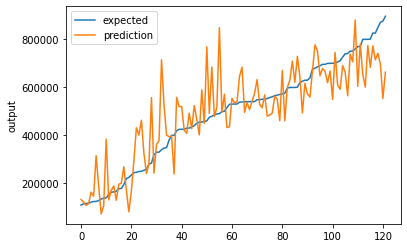

In [ ]:
model.compile(loss="mean_squared_error", optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) 
# save best model
model.fit([x_train,img_train], y_train, validation_data= ([x_test, img_test], y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights.hdf5')
pred = model.predict([x_test, img_test])

# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(rmse))

#regression lift Chart
chart_regression(pred.flatten(), y_test.to_numpy(), sort=True)